In [204]:
function init()
    I = 1000
    u = zeros(Float64,I+1)
    x = zeros(Float64,I+1)
    l = zeros(Float64,I)
    p = zeros(Float64,I)
    ρ = zeros(Float64,I)
    m = zeros(Float64,I)
    e = zeros(Float64,I)
    γ = 1.4
    
    Δx = 1/I
    l .= Δx
    
    tt = 0.14
    sf =0.1
    # init
    
    for i in 1:I 
        u[i] = 0
        
        
        if i >I/2
            p[i] = 0.1
            ρ[i] = 0.1
            m[i] =ρ[i]*Δx
        else
            p[i] = 1.0
            ρ[i] = 1.0
            m[i] = ρ[i]*Δx
        end
    end
    
    for i in 1:I+1
        x[i] = i*Δx
    end
    
    
    e = pToe(p,ρ,γ)
return sf,tt,γ,u,x,m,p
end

            
            

init (generic function with 1 method)

In [15]:
function pToe(p,ρ,γ)
    return p ./ ρ/(γ-1)
end
function eTop(e,ρ,γ)
    return (γ-1)*ρ .* e
end

eTop (generic function with 1 method)

In [192]:
function timeSolve(sf, tt,γ,u,x,m,p)
    t= 0.0

    I, = size(m)
    ρ = zeros(Float64,I)
       while t<tt
#for i in 1:1
        dt=CFL(sf,γ,x,u,p,m)
        if t+dt>tt
           dt = tt-t
        end
        u,x,p,ρ = Euler1st(γ,dt,u,x,p,m)
        t += dt
        
        println(t)
    end
#
    return u,x,p,ρ
end

timeSolve (generic function with 1 method)

### 根据质量求解密度

$$l_i = x_{i+1/2} - x_{i-1/2}$$
$$\rho = m/l$$
$$e = \frac{p}{(\gamma -1)\rho}$$

### 添加人工粘性

$$p = p + q$$
$$q_i = \left\{ \begin{aligned}
1.5\rho_il_ic_i|\frac{\partial u}{\partial x}|
            +0.06\rho_il_i^2\left(\frac{\partial u}{\partial x}\right)^2  \quad \text{if} \quad \frac{\partial u}{\partial x} <0\\
            0 \text{else}
            \end{aligned} \right.
            $$

### 右端项

$$\text{rhsu}_{i+1/2} = -\frac{(p_{i+1}- p_i)}{m_{p,i+1/2}}$$
$$\text{rhse}_i = -\frac{p_i(u_{i+1/2}-u_{i-1/2})}{m_i}$$

$$m_{p,i+1/2} \approx \frac{m_{i}+m_{i+1}}{2}$$

### 推进

$$ x  = x +dt* u$$
$$ u = u + dt* \text{rhsu}$$
$$ e = e + dt* \text{rhse}$$

### 求解新的密度和压力

$$l_i = x_{i+1/2} - x_{i-1/2}$$
$$\rho = m/l$$
$$ p = (\gamma -1)\rho e$$


In [196]:
function Euler1st(γ,dt,u,x,p,m)
    I, = size(p)
    
    l = zeros(Float64,I)
    x₀ = zeros(Float64,I+1)
    u₀ = zeros(Float64,I+1)
    e₀ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l     
    e = pToe(p, ρ,γ)    
    
    p = artificial_viscosity!(γ,l,p,ρ,x,u) 
      
    rhsu, rhse = Rhs(x,l,u,p,m)
  
    x₀  = x+ dt .* u
    u₀  = u+ dt .* rhsu
    e₀  = e+ dt .* rhse
    

    
    for i in 1:I
        l[i] = x₀[i+1]-x₀[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
#    p = artificial_viscosity!(γ,l,p,ρ,x₀,u₀)
    
    rhsu₀, rhse₀ = Rhs(x₀,l,u₀,p,m)
    
    x  += 1/2 *dt*(u +u₀)
    u  += 1/2 *dt*(rhsu + rhsu₀)
    e  += 1/2 *dt*(rhse + rhse₀)
    
    for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    p = eTop(e, ρ,γ)
    
    
    return u,x,p,ρ
end

Euler1st (generic function with 1 method)

## 预估校正方法 （二阶）

$$\frac{dy}{dx} = f(x,y)$$

$$y_0 = y_n + dx f(x_n,y_n)$$

$$y_{n+1} = y_n + \frac{1}{2} dx [f(x_n, y_n) + f(x_{n+1},y_0)] $$

In [206]:
function Rhs(x,l,u,p,m)
    I, = size(m)
    rhsu = zeros(Float64,I+1)
    rhse = zeros(Float64,I)
    for i in 1:I-1
        rhsu[i+1] = - 2(p[i+1] - p[i])/(m[i] +m[i+1])
    end
    for i in 1:I
        rhse[i] = - p[i]*(u[i+1]-u[i])/m[i]
    end

    return rhsu,rhse
    
    end
    

Rhs (generic function with 1 method)

In [159]:
function artificial_viscosity!(γ, l,p,ρ,x,u)
    I, = size(p)
    for i in 1:I
        c = √(γ*p[i]/ρ[i])
        ∂u_∂x = (u[i+1]- u[i])/(x[i+1]-x[i])
        q = 0
        if ∂u_∂x < 0 
        q = 4ρ[i]*l[i]*c*abs(∂u_∂x)
            +4ρ[i]*l[i]^2*(∂u_∂x)^2 
        end
        p[i] = p[i] +q
    
    end
    return p
end

artificial_viscosity! (generic function with 1 method)

In [20]:
  function CFL(sf,γ,x,u,p,m)
    dlmin = 1e8
    umax = 0.0
    I, = size(p)
    l = zeros(Float64,I)
    ρ = zeros(Float64,I)
    
     for i in 1:I
        l[i] = x[i+1]-x[i]
    end
    
    ρ = m ./ l
    for i in 1:I
        c  = √(γ*p[i]/ρ[i])
        u2 = u[i] + c 
        if abs(u2) > umax
            umax = abs(u2)
        end
        if l[i] < dlmin
            dlmin = l[i]
        end
    end
    cfl = dlmin/umax*sf
    return cfl
end

CFL (generic function with 1 method)

In [207]:
sf,tt,γ,u,x,m,p = init()
u,x,p,ρ = timeSolve(sf, tt, γ, u, x, m,p)

8.451542547283764e-5
0.00016362287675550228
0.00023793282710370573
0.0003079896418646198
0.0003742717147062606
0.0004371950536656887
0.0004971196959366322
0.0005543569591633762
0.000609176425965461
0.0006618121988495478
0.0007124682983603904
0.0007613232325393157
0.0008085338274961718
0.0008542384254126345
0.0008985595525267135
0.0009416061479805947
0.0009834754307263582
0.0010242544685787167
0.0010640215019749365
0.0011028470652854811
0.0011407949405199116
0.0011779229717720084
0.0012142837635005586
0.001249925281518578
0.0012848913721647782
0.0013192222123926587
0.001352954701300604
0.0013861228018341182
0.0014187578399339367
0.0014508887672138452
0.0014825423922768457
0.0015137435849756054
0.0015445154572597724
0.001574879523702375
0.0016048558443391649
0.0016344631520713558
0.0016637189665606642
0.0016926396962746683
0.0017212407301116922
0.0017495365198404566
0.0017775406544248526
0.001805265927163606
0.001832724396454402
0.001859927440888986
0.0018868858092972382
0.00191360966628

0.01116299904936217
0.011183626771254705
0.011204253776407035
0.011224880093553012
0.011245505750863846
0.01126613077632571
0.011286755197851626
0.01130737904296643
0.0113280023388378
0.01134862511230749
0.011369247389921889
0.011389869197961273
0.011410490562467238
0.011431111509267894
0.011451732064000436
0.0114723522521308
0.01149297209897011
0.011513591629687708
0.011534210869320537
0.011554829842778723
0.011575448573524301
0.01159606708290607
0.011616685390597936
0.011637303347886853
0.011657920489665543
0.011678536847214899
0.01169915245080151
0.011719767329724453
0.011740381512370585
0.011760995026274503
0.011781607898180628
0.011802220154105612
0.011822831819399856
0.011843442918807196
0.011864053476522083
0.011884663516243708
0.011905273061226651
0.011925882134321828
0.011946490757971108
0.011967098954247501
0.011987706744891068
0.012008314151340646
0.01202892119476126
0.012049527896067135
0.012070134275937875
0.012090740354826355
0.01211134615295882
0.012131951688486393
0.012

0.021328063663415234
0.021348534687124977
0.021369005551940875
0.021389476262486662
0.02140994682328443
0.021430417238754287
0.02145088751320223
0.021471357650814836
0.02149182765565829
0.02151229753167998
0.021532767282711654
0.02155323691247339
0.021573706424578013
0.021594175822535623
0.021614645109757948
0.021635114289562395
0.021655583365175802
0.02167605233973787
0.021696521216304283
0.021716989971860355
0.021737458514783415
0.02175792685044032
0.021778394984075838
0.021798862920815315
0.021819330665667252
0.021839798223525823
0.021860265599173305
0.021880732797282452
0.02190119982241878
0.021921666679042776
0.02194213337151207
0.021962599904083502
0.02198306628091515
0.022003532506068308
0.022023998583509376
0.02204446451711174
0.022064930310657562
0.022085395967839566
0.022105861492262756
0.02212632688744609
0.022146792156824156
0.022167257303748758
0.022187722331490526
0.02220818724324046
0.022228652042111458
0.022249116731139846
0.022269581313286827
0.02229004579143997
0.0223

0.0386314528941135
0.03865185663433376
0.03867226034372235
0.038692664022712465
0.03871306767172925
0.03873347129118993
0.03875387488150396
0.03877427844307316
0.038794681976291844
0.038815085481546975
0.038835488959218276
0.03885589240887999
0.03887629581896972
0.038896699190077134
0.03891710252278114
0.03893750581765008
0.0389579090752419
0.038978312296104364
0.0389987154807752
0.0390191186297823
0.039039521743643876
0.039059924822868644
0.03908032786795597
0.03910073087939607
0.03912113385767013
0.0391415368032505
0.03916193971660082
0.039182342598176205
0.03920274544842336
0.03922314826778076
0.03924355105667878
0.03926395381553985
0.039284356544778555
0.039304759244801826
0.039325161916009065
0.03934556455879224
0.039365967173536055
0.03938636976061807
0.03940677232040883
0.03942717485327197
0.03944757735956436
0.039467979839636215
0.03948838228909541
0.03950878470130166
0.03952918707679806
0.039549589416117824
0.039569991719784446
0.03959039398831188
0.0396107962222047
0.03963119

0.048952434200920436
0.04897282634193985
0.04899321846916444
0.04901361058086584
0.04903400267571494
0.04905439475386441
0.049074786815464226
0.04909517886066176
0.04911557088960183
0.04913596290242669
0.04915635489927614
0.049176746880287524
0.04919713884559578
0.04921753079533352
0.049237922729631
0.04925831464861622
0.04927870655241496
0.049299098441150775
0.049319490314945084
0.04933988217391718
0.04936027401818426
0.04938066584786149
0.049401057663062006
0.049421449463896996
0.04944184125047568
0.0494622330229054
0.0494826247812916
0.04950301652573788
0.04952340825634606
0.04954379997321616
0.049564191676446455
0.04958458336613352
0.04960497504237223
0.04962536670525582
0.049645758354875884
0.04966614998982819
0.0496865416087501
0.04970693321177997
0.04972732479905375
0.04974771637070504
0.04976810792686511
0.04978849946766295
0.04980889099322531
0.04982928250367674
0.049849673999139636
0.049870065479734244
0.04989045694557875
0.04991084839678926
0.049931239833479885
0.04995163125

0.06615950649402562
0.06617989066385435
0.06620027482774925
0.06622065898571694
0.06624104313776408
0.06626142728389726
0.06628181142412311
0.06630219555844821
0.06632257968687916
0.06634296380942252
0.06636334792608486
0.06638373203687274
0.06640411614179269
0.06642450024085124
0.0664448843340549
0.0664652684214102
0.06648565250292363
0.06650603657860166
0.06652642064845078
0.06654680471247747
0.06656718877068815
0.06658757282308929
0.06660795686968732
0.06662834091048866
0.06664872494549974
0.06666910897472696
0.0666894929981767
0.06670987701585536
0.06673026102776933
0.06675064503392496
0.0667710290343286
0.06679141302898663
0.06681179701790536
0.06683218100109115
0.0668525649785503
0.06687294895028913
0.06689333291631394
0.06691371687663103
0.06693410083124669
0.06695448478013516
0.066974868723228
0.06699525266053169
0.06701563659205269
0.06703602051779746
0.06705640443777243
0.06707678835198404
0.0670971722604387
0.06711755616314283
0.06713794006010282
0.06715832395132507
0.067178

0.07669743388615897
0.07671781556594798
0.07673819724190137
0.07675857891402318
0.07677896058231747
0.07679934224678824
0.07681972390743952
0.07684010556427534
0.07686048721729971
0.07688086886651664
0.07690125051193013
0.07692163215354417
0.07694201379136276
0.07696239542538988
0.07698277705559842
0.07700315868195698
0.07702354030446962
0.0770439219231404
0.07706430353797337
0.07708468514897258
0.07710506675614207
0.07712544835948586
0.07714582995900798
0.07716621155471245
0.07718659314660331
0.07720697473468456
0.0772273563189602
0.07724773789943425
0.07726811947611067
0.0772885010489935
0.0773088826180867
0.07732926418339425
0.07734964574492013
0.07737002730266833
0.07739040885664279
0.07741079040684748
0.07743117195328635
0.07745155349596336
0.07747193503488245
0.07749231657004757
0.07751269810146263
0.0775330796291316
0.07755346115305836
0.07757384267324686
0.07759422418970102
0.07761460570242473
0.0776349872114219
0.07765536871669643
0.07767575021825221
0.07769613171609313
0.0777

0.09481552514634482
0.09483590435092366
0.0948562835535447
0.09487666275420957
0.09489704195291992
0.0949174211496774
0.09493780034448365
0.09495817953734031
0.09497855872824904
0.09499893791721144
0.09501931710422917
0.09503969628930387
0.09506007547243714
0.09508045465361738
0.09510083383283266
0.09512121301008465
0.09514159218537502
0.09516197135870541
0.09518235053007747
0.09520272969949287
0.09522310886695323
0.09524348803246023
0.0952638671960155
0.09528424635762067
0.0953046255172774
0.09532500467498733
0.0953453838307521
0.09536576298457332
0.09538614213645265
0.09540652128639171
0.09542690043439214
0.09544727958045557
0.09546765872458361
0.0954880378667779
0.09550841700704005
0.09552879614537167
0.09554917528177441
0.09556955441624986
0.09558993354879965
0.09561031267942538
0.09563069180812866
0.09565107093491111
0.09567145005977434
0.09569182918271994
0.09571220830374953
0.0957325874228647
0.09575296654006704
0.09577334565535817
0.09579372476873965
0.09581410388021311
0.09583

0.10537171776000205
0.10539209610339481
0.10541247444538149
0.1054328527859631
0.10545323112514068
0.10547360946291527
0.1054939877992879
0.10551436613425959
0.10553474446783136
0.10555512280000423
0.10557550113077925
0.10559587946015742
0.10561625778813977
0.10563663611472732
0.1056570144399211
0.10567739276372211
0.10569777108613138
0.10571814940714992
0.10573852772677876
0.10575890604501889
0.10577928436187134
0.10579966267733712
0.10582004099141724
0.10584041930411271
0.10586079761542454
0.10588117592535373
0.1059015542339013
0.10592193254106823
0.10594231084685556
0.10596268915126426
0.10598306745429537
0.10600344575594986
0.10602382405622876
0.10604420235513305
0.10606458065266373
0.1060849589488218
0.10610533724360827
0.10612571553702412
0.10614609382907034
0.10616647211974793
0.10618685040905788
0.1062072286970012
0.10622760698357885
0.10624798526879183
0.10626836355264112
0.10628874183512772
0.10630912011625261
0.10632949839601678
0.10634987667442121
0.10637025495146687
0.1063

0.12416005210546181
0.12418042945438786
0.12420080680248609
0.124221184149757
0.12424156149620105
0.12426193884181876
0.12428231618661056
0.12430269353057698
0.12432307087371848
0.12434344821603553
0.12436382555752863
0.12438420289819825
0.12440458023804488
0.12442495757706898
0.12444533491527104
0.12446571225265154
0.12448608958921097
0.12450646692494978
0.12452684425986847
0.12454722159396751
0.12456759892724738
0.12458797625970854
0.12460835359135147
0.12462873092217665
0.12464910825218455
0.12466948558137565
0.12468986290975043
0.12471024023730935
0.12473061756405289
0.12475099488998152
0.12477137221509572
0.12479174953939597
0.1248121268628827
0.12483250418555643
0.12485288150741759
0.12487325882846669
0.12489363614870416
0.1249140134681305
0.12493439078674616
0.12495476810455163
0.12497514542154735
0.12499552273773382
0.12501590005311147
0.1250362773676808
0.12505665468144228
0.12507703199439635
0.12509740930654348
0.12511778661788414
0.1251381639284188
0.12515854123814793
0.1251

0.13475617144739174
0.13477654841932774
0.13479692539062618
0.1348173023612874
0.13483767933131172
0.13485805630069947
0.134878433269451
0.13489881023756664
0.13491918720504673
0.13493956417189157
0.1349599411381015
0.13498031810367686
0.13500069506861798
0.13502107203292518
0.13504144899659878
0.13506182595963914
0.13508220292204656
0.13510257988382138
0.13512295684496392
0.13514333380547452
0.13516371076535352
0.13518408772460125
0.135204464683218
0.13522484164120413
0.13524521859855995
0.1352655955552858
0.135285972511382
0.13530634946684886
0.13532672642168672
0.13534710337589592
0.1353674803294768
0.13538785728242964
0.1354082342347548
0.13542861118645255
0.1354489881375233
0.1354693650879673
0.1354897420377849
0.13551011898697646
0.13553049593554226
0.13555087288348264
0.1355712498307979
0.1355916267774884
0.13561200372355445
0.13563238066899636
0.13565275761381446
0.13567313455800906
0.1356935115015805
0.13571388844452908
0.13573426538685515
0.13575464232855902
0.135775019269641

([0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 4.73022e-17, 0.0  …  0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0], [0.001, 0.002, 0.003, 0.004, 0.005, 0.006, 0.007, 0.008, 0.009, 0.01  …  0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 1.0, 1.001], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1], [1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0  …  0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1, 0.1])

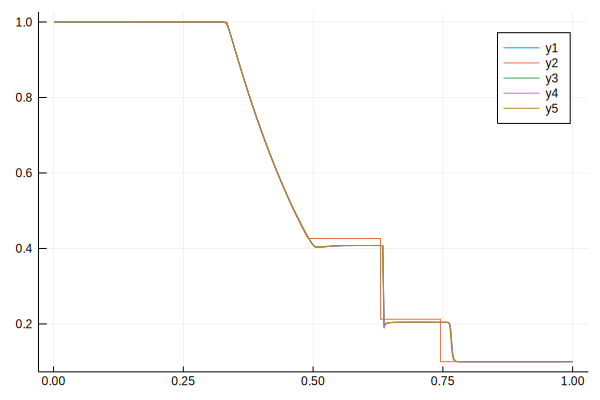

In [208]:
#using Plots
plot!(x[1:end-1],ρ)
#plot!(x1 .+ 0.5,U[:,1])

In [100]:
push!(LOAD_PATH, "/home/bfly/workspace/computeforcfd/Lag2D/")

6-element Array{String,1}:
 "@"                                        
 "@v#.#"                                    
 "@stdlib"                                  
 "/home/bfly/workspace/computeforcfd/Lag2D/"
 "/home/bfly/workspace/computeforcfd/Lag2D/"
 "/home/bfly/workspace/computeforcfd/Lag2D/"

In [10]:
using Riemann

In [136]:
Wₗ = W(1.0,0.0,1.0)
Wᵣ = W(0.1,0.0,0.1)
γ = 1.4
x1,U = SolveDistr(0.14,Wₗ,Wᵣ,γ)

([-0.3313, -0.330472, -0.329644, -0.328816, -0.327987, -0.327159, -0.326331, -0.325503, -0.324674, -0.323846  …  0.478339, 0.479565, 0.480792, 0.482018, 0.483245, 0.484471, 0.485698, 0.486924, 0.488151, 0.489377], [1.0 0.0 1.0; 1.0 0.0 1.0; … ; 0.1 0.0 0.1; 0.1 0.0 0.1])

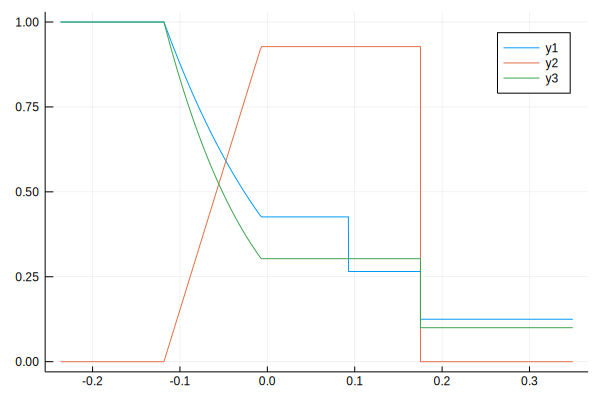

In [37]:
plot(x1,U)